<a href="https://colab.research.google.com/github/jmoranrun/HAR_Dist_ML/blob/main/Pruning_HAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Pruning Experiments around Personalization for Human Actvity Recognition. 
I used the Keras Notebook "Magnitude-based weight pruning with Keras" as a reference.

This notebook was used to run the experiments in the presentation:
Human Activity Recognition in a Distributed Machine Learning System. Jul 26, 2021  IEEE International Conference on Wearable and Implantable Body Sensor Networks (BSN2021)





The experiments in this notebook evaluate the effects of model pruning in a distributed ML system for Human Actvity Recongition (HAR).  Models are trained centrally and then distributed to edge users. Two types of edge users are considered.

(1) Edge users that have mode training capabilites 

(2) Edge users that don't have mode training capabilites 


Due to long run times, results are written to files and analysed in a separate notebook.

## Flows to evaluate the effect of Pruning when the edge device can train

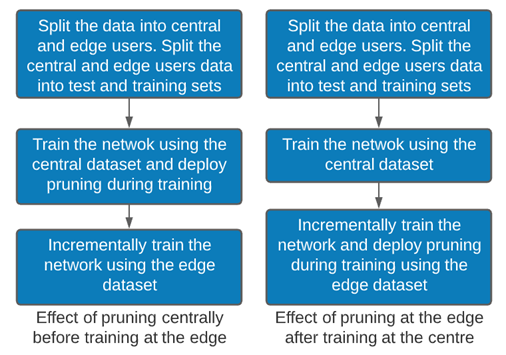

## Flows for evaluating pruning when the edge cannot train
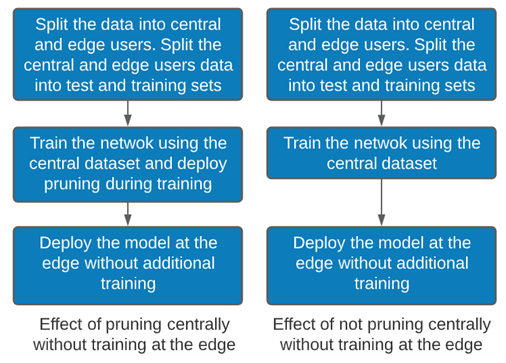

In [ ]:
! pip install -q tensorflow-model-optimization

In [ ]:
%load_ext tensorboard
from google.colab import drive
drive.mount('/content/drive')
import tensorboard
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from tensorflow import keras
import tensorflow_model_optimization as tfmot
import random 
# Import the HAR Class for manipulation of the HAR Dataset
!cp /content/drive/MyDrive/Har_Data.py .
import Har_Data



The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
#config = tf.compat.v1.ConfigProto()
#config.gpu_options.allow_growth = True
#tf.enable_eager_execution()

import tempfile
import zipfile
import os

###Define helper functions
A function is defined to count the number of weights that are set to zero. The purpose of this function is to confirm the sparsity of the model. 
This method was referenced from https://www.dlology.com/blog/how-to-compress-your-keras-model-x5-smaller-with-tensorflow-model-optimization/
Note, the method to move data from the test to training dataset is not currently used in these experiments 



In [ ]:
# load a single file as a numpy array
def load_file(filepath):
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
  return dataframe.values
 
#ref: https://www.dlology.com/blog/how-to-compress-your-keras-model-x5-smaller-with-tensorflow-model-optimization/ 

def check_zero_weights(model):
  #print(model.get_weights())
  for i, w in enumerate(model.get_weights()):
    print(
        "{} -- Total:{}, Zeros: {:.2f}%".format(
            model.weights[i].name, w.size, np.sum(w == 0) / w.size * 100
        )        
    )
    zero_idx=np.where(w == 0)
    print("i iddex is zero_idx is", i, zero_idx)  



### Define the CNN Model
In this cell the CNN is defined.
It's initial weights are saved so that all experiments start from the same point to ensure fairness in the comparisions.


In [ ]:
##############################################
#### Define the CNN ##########################        
##############################################
# set variables
mix_users=True
seg_len = 128
num_channels = 9
num_labels = 6
batch_size = 100
learning_rate = 0.001
num_epoches = 0
#num_batches = train_x.shape[0] // batch_size
time_samples = 128
feature_sensors = 9
num_classes = 6


#tf.compat.v1.disable_eager_execution()
l = tf.keras.layers

opt = 'adam'
l = tf.keras.layers
model_har = tf.keras.Sequential([
    l.Conv1D(filters=32,kernel_size=10,strides=1,activation='relu', input_shape=(time_samples, feature_sensors)),
    l.MaxPooling1D(pool_size=4,strides=2, padding='same'),
    l.Conv1D(filters=64,kernel_size=2,strides=1,activation='relu'),
    l.MaxPooling1D(pool_size=4,strides=2, padding='same'),
    l.Conv1D(filters=128,kernel_size=2,strides=2,activation='relu'),
    l.Flatten(),
    l.Dense(150),
    l.Activation('tanh'),
    l.Dropout(0.5),
    l.Dense(50),
    l.Activation('tanh'),
    l.Dropout(0.5),
    l.Dense(25),
    l.Activation('tanh'),
    l.Dropout(0.5),
    l.Dense(num_labels),
    l.Activation('softmax')
])

model_har.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

## This NB needs to be run multiple times for one data collection due to 
## large computation effort.  Only write out the init weights once per
## data collection run to keep comparisions equal
gen_init_weights = True
if(gen_init_weights):
  model_har.save_weights('/content/drive/My Drive/port_model_har_pruning_init.h5')



print(model_har.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_15 (Conv1D)          (None, 119, 32)           2912      
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 60, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_16 (Conv1D)          (None, 59, 64)            4160      
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 30, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_17 (Conv1D)          (None, 15, 128)           16512     
                                                                 
 flatten_7 (Flatten)         (None, 1920)             

## Define The Pruning Flow
This method is the backbone of the pruning experiments. 
It creates edge and central datasets. 

Pruning at the central node can be enabled/disabled through switch prune_at_center

Pruning at the edge nodes can be enabled/disabled through switch prune_at_edge

Training at the edge nodes can be enabled/disabled through switch train_at_edge

Training at the central nodes is always enabled 



In [ ]:
def run_prune(prune_at_edge, prune_at_center, train_at_edge, har_dataset, har_dataset_y, sub_map, edge_central_ratio, num_epoches = 25, eval_before_prune=False):

  total_num_users=30
  all_users = range(1, total_num_users)
  edge_users = random.sample(all_users, int(edge_central_ratio*total_num_users))
  #model_har.load_weights('/content/drive/My Drive/model_har_init.h5')
  central_users=np.setdiff1d(all_users, edge_users)
  print("Edge users are:",edge_users)
  print("Central users are:",central_users)

  # Create an object of type HAR_Data, used to manipulate the data
  har_data = Har_Data.Har_Data(har_dataset, har_dataset_y, sub_map, edge_users, central_users)
  # Currently percent_mix is always set to zero in these experiments 
  percent_mix=0
  edge_x, edge_submap, edge_y, central_x, central_submap, central_y = \
        har_data.select_user_val(percent_mix)

  central_train_x, central_test_x, central_train_y, central_test_y = train_test_split(central_x, central_y, test_size = 0.2, random_state = 0,shuffle =True)
  edge_train_x, edge_test_x, edge_train_y, edge_test_y = train_test_split(edge_x, edge_y, test_size = 0.2, random_state = 0,shuffle =True)

  logdir = tempfile.mkdtemp()
  print('Writing training logs to ' + logdir)
  callbacks = [tf.keras.callbacks.TensorBoard(log_dir=logdir, profile_batch=0)]
  
  model_har.load_weights('/content/drive/My Drive/port_model_har_pruning_init.h5')
  if(eval_before_prune== True):
    model_har.fit(central_train_x, central_train_y,
           batch_size=batch_size,
           epochs=num_epoches,
           verbose=0,
           callbacks=callbacks,
           validation_data=(central_test_x, central_test_y))
    score = model_har.evaluate(central_test_x, central_test_y, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    check_zero_weights(model_har)

  num_train_samples = central_train_x.shape[0]
  end_step = np.ceil(1.0 * num_train_samples / batch_size).astype(np.int32) * num_epoches
  print('End step: ' + str(end_step))

## Set the pruning paras depending on whether pruning is to be done centrally or not 
  if(prune_at_center==True):
   pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                   final_sparsity=0.75,
                                                   begin_step=100,
                                                   end_step=end_step,
                                                   frequency=100)
    }
  else:
    pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.0,
                                                   final_sparsity=0.0,
                                                   begin_step=100,
                                                   end_step=end_step,
                                                   frequency=100)
   }

  
  prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

  central_model_har = prune_low_magnitude(model_har, **pruning_params)

  central_model_har.compile(
     loss=tf.keras.losses.categorical_crossentropy,
     optimizer='adam',
     metrics=['accuracy'])

# Add a pruning step callback to peg the pruning step to the optimizer's
# step. Also add a callback to add pruning summaries to tensorboard
  callbacks = [
     tfmot.sparsity.keras.UpdatePruningStep(),
     tfmot.sparsity.keras.PruningSummaries(log_dir=logdir, profile_batch=0)
  ]

  central_model_har.fit(central_train_x, central_train_y,
           batch_size=batch_size,
           epochs=num_epoches,
           callbacks=callbacks)


  score = central_model_har.evaluate(central_test_x, central_test_y, verbose=0)
  print('Test loss:', score[0])
  print('Test accuracy:', score[1])
  check_zero_weights(central_model_har)
  central_model_har.save_weights('/content/drive/My Drive/port_pruned_model_har_central.h5')

  if(prune_at_edge==True):
   pruning_params_edge = {
         'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                    final_sparsity=0.75,
                                                     begin_step=100,
                                                    end_step=end_step,
                                                     frequency=100)
   }
  else:
   pruning_params_edge = {
         'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.0,
                                                    final_sparsity=0.0,
                                                    begin_step=100,
                                                    end_step=end_step,
                                                    frequency=100)
   }

  edge_pruned_model_har = prune_low_magnitude(model_har, **pruning_params)

  edge_pruned_model_har.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer='adam',
    metrics=['accuracy'])
  

  if(prune_at_edge==True):          ## If Prune at edge take the model which has not had pruning done and apply the appriate weights from the central model (pruning can't be appied twice to a model)
   edge_pruned_model_har=edge_pruned_model_har
   edge_pruned_model_har.load_weights('/content/drive/My Drive/port_pruned_model_har_central.h5')
  else:
   edge_pruned_model_har=central_model_har

# Add a pruning step callback to peg the pruning step to the optimizer's
# step. Also add a callback to add pruning summaries to tensorboard

  callbacks = [
     tfmot.sparsity.keras.UpdatePruningStep(),
     tfmot.sparsity.keras.PruningSummaries(log_dir=logdir, profile_batch=0)
  ]

 
  if(train_at_edge==True):
   edge_pruned_model_har.fit(edge_train_x, edge_train_y,
           batch_size=batch_size,
           epochs=num_epoches,
           verbose=0,
           callbacks=callbacks,
           validation_data=(edge_test_x, edge_test_y))

  score = edge_pruned_model_har.evaluate(edge_test_x, edge_test_y, verbose=0)
  print('Edge Test loss:', score[0])
  print('Edge Test accuracy:', score[1])
  edge_acc =  score[1]

  score = central_model_har.evaluate(central_test_x, central_test_y, verbose=0)
  print('Central Test loss:', score[0])
  print('Central accuracy:', score[1])
  central_acc =  score[1]
  print(edge_pruned_model_har.summary())
  check_zero_weights(edge_pruned_model_har)

  return  central_acc, edge_acc 




### Prepare The Dataset and set the Run_prune parameters




In [ ]:

## This files contains the training users mapping
sub_map_train = load_file('/content/drive/My Drive/Colab Notebooks/UCI_dataset/UCI HAR Dataset/train/subject_train.txt')
train_subjects = np.unique(sub_map_train)
print(train_subjects)
 
sub_map_test = load_file('/content/drive/My Drive/Colab Notebooks/UCI_dataset/UCI HAR Dataset/test/subject_test.txt')
test_subjects = np.unique(sub_map_test)
print(test_subjects)
 
 
har_features = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]
 
num_of_timesamples = 128
num_of_feature = len(har_features)
num_of_samples = sub_map_train.shape[0] + sub_map_test.shape[0]
print("num_of_samples is",num_of_samples)

sub_map = np.concatenate((sub_map_test, sub_map_train), axis =0)
sub_map = sub_map.reshape(-1) 
print(sub_map)
unique, counts = np.unique(sub_map, return_counts=True)
print(dict(zip(unique, counts)))


#########################################################################################################
# har_dataset is a 3-D np array of form: [num_of_samples, num_of_timesamples, num_of_feature]
#             Where num_of_samples is the total number of recorded activites 
#                   num_of_timesamples is the total number of timesammples in each recorded activity 
#                   num_of_feature is the total number of features recorded using the smartphones.
#########################################################################################################

har_feature_cnt=0
har_dataset =  np.empty([num_of_samples, num_of_timesamples, num_of_feature])
for har_feature in har_features:
   har_feature_test  = load_file(f'/content/drive/My Drive/Colab Notebooks/UCI_dataset/UCI HAR Dataset/test/Inertial Signals/{har_feature}_test.txt')
   har_feature_train = load_file(f'/content/drive/My Drive/Colab Notebooks/UCI_dataset/UCI HAR Dataset/train/Inertial Signals/{har_feature}_train.txt')
   har_feature = np.concatenate((har_feature_test, har_feature_train), axis=0)
   har_dataset[:, :, har_feature_cnt] = har_feature 
   har_feature_cnt += 1
 
har_dataset_with_subject = np.expand_dims(har_dataset, axis=1)
print("har_dataset_with_subject.shape is",har_dataset_with_subject.shape)
 
train_y =  load_file('/content/drive/My Drive/Colab Notebooks/UCI_dataset/UCI HAR Dataset/train/y_train.txt')
test_y =  load_file('/content/drive/My Drive/Colab Notebooks/UCI_dataset/UCI HAR Dataset/test/y_test.txt')
train_y = np.asarray(pd.get_dummies(train_y.reshape(-1, )))
test_y = np.asarray(pd.get_dummies(test_y.reshape(-1, )))
har_dataset_y = np.concatenate((test_y,train_y),axis=0)

#jmoran shorten the runs for a sanity check
#num_runs_per_edge_ratio=20
num_runs_per_edge_ratio=2
#edge_central_ratio_lst = [0.4, 0.5, 0.6, 0.7, 0.8]
edge_central_ratio_lst = [0.4, 0.5]



[ 1  3  5  6  7  8 11 14 15 16 17 19 21 22 23 25 26 27 28 29 30]
[ 2  4  9 10 12 13 18 20 24]
num_of_samples is 10299
[ 2  2  2 ... 30 30 30]
{1: 347, 2: 302, 3: 341, 4: 317, 5: 302, 6: 325, 7: 308, 8: 281, 9: 288, 10: 294, 11: 316, 12: 320, 13: 327, 14: 323, 15: 328, 16: 366, 17: 368, 18: 364, 19: 360, 20: 354, 21: 408, 22: 321, 23: 372, 24: 381, 25: 409, 26: 392, 27: 376, 28: 382, 29: 344, 30: 383}
har_dataset_with_subject.shape is (10299, 1, 128, 9)


### Run Pruning experiment with: 
prune_at_edge=False

prune_at_center=False

train_at_edge=False

Results will be printed to file 



In [ ]:
prune_at_edge=False
prune_at_center=False
train_at_edge=False


central_acc_lst=[]
edge_acc_lst=[]

for edge_central_ratio in edge_central_ratio_lst:
  for run in range(num_runs_per_edge_ratio):
    central_acc, edge_acc = run_prune(prune_at_edge=prune_at_edge, prune_at_center=prune_at_center, train_at_edge=train_at_edge, har_dataset=har_dataset, har_dataset_y=har_dataset_y, sub_map=sub_map, edge_central_ratio=edge_central_ratio)
    central_acc_lst.append(central_acc)
    edge_acc_lst.append(edge_acc)

with open('/content/drive/My Drive/port_pef_pcf_tef_bl_20.txt', 'w') as f:
        f.writelines("%s\n" % central_acc_lst)
        f.writelines("%s\n" % edge_acc_lst)   
print("central_acc_lst is", central_acc_lst)
print("edge_acc_lst is",edge_acc_lst)


### Run Pruning experiment with: 
prune_at_edge=False

prune_at_center=True

train_at_edge=False

Results will be printed to file

In [ ]:

prune_at_edge=False
prune_at_center=True
train_at_edge=False

central_acc_lst1=[]
edge_acc_lst1=[]


for edge_central_ratio in edge_central_ratio_lst:
  for run in range(num_runs_per_edge_ratio):
    central_acc, edge_acc = run_prune(prune_at_edge=prune_at_edge, prune_at_center=prune_at_center, train_at_edge=train_at_edge, har_dataset=har_dataset, har_dataset_y=har_dataset_y, sub_map=sub_map, edge_central_ratio=edge_central_ratio)
    central_acc_lst1.append(central_acc)
    edge_acc_lst1.append(edge_acc)

with open('/content/drive/My Drive/port_pef_pct_tef_bl_20.txt', 'w') as f:
        f.writelines("%s\n" % central_acc_lst1)
        f.writelines("%s\n" % edge_acc_lst1)   

print("central_acc_lst is", central_acc_lst1)
print("edge_acc_lst is",edge_acc_lst1)

### Run Pruning experiment with: 

prune_at_edge=False

prune_at_center=True

train_at_edge=True

Results will be printed to file

In [ ]:

prune_at_edge=False
prune_at_center=True
train_at_edge=True

central_acc_lst2=[]
edge_acc_lst2=[]

for edge_central_ratio in edge_central_ratio_lst:
  for run in range(num_runs_per_edge_ratio):
    central_acc, edge_acc = run_prune(prune_at_edge=prune_at_edge, prune_at_center=prune_at_center, train_at_edge=train_at_edge, har_dataset=har_dataset, har_dataset_y=har_dataset_y, sub_map=sub_map, edge_central_ratio=edge_central_ratio)
    central_acc_lst2.append(central_acc)
    edge_acc_lst2.append(edge_acc)

with open('/content/drive/My Drive/port_pef_pct_tet_bl_20.txt', 'w') as f:
        f.writelines("%s\n" % central_acc_lst2)
        f.writelines("%s\n" % edge_acc_lst2)   

print("central_acc_lst is", central_acc_lst2)
print("edge_acc_lst is",edge_acc_lst2)

### Run Pruning experiment with: 
prune_at_edge=True

prune_at_center=False

train_at_edge=True

Results will be printed to file

In [ ]:

prune_at_edge=True
prune_at_center=False
train_at_edge=True

central_acc_lst3=[]
edge_acc_lst3=[]

for edge_central_ratio in edge_central_ratio_lst:
  for run in range(num_runs_per_edge_ratio):
    central_acc, edge_acc = run_prune(prune_at_edge=prune_at_edge, prune_at_center=prune_at_center, train_at_edge=train_at_edge, har_dataset=har_dataset, har_dataset_y=har_dataset_y, sub_map=sub_map, edge_central_ratio=edge_central_ratio)
    central_acc_lst3.append(central_acc)
    edge_acc_lst3.append(edge_acc)

with open('/content/drive/My Drive/port_pet_pcf_tet_bl_20.txt', 'w') as f:
        f.writelines("%s\n" % central_acc_lst3)
        f.writelines("%s\n" % edge_acc_lst3)   

print("central_acc_lst is", central_acc_lst3)
print("edge_acc_lst is",edge_acc_lst3)